<a href="https://colab.research.google.com/github/32213160/AISecApp_Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 하드웨어 모니터링 데이터셋 확보 및 실시간 이상 감지 시스템

## 0. 필요한 라이브러리 설치 및 불러오기

In [1]:
!pip install requests pandas scikit-learn matplotlib

In [ ]:
!pip install --upgrade jupyter_http_over_ws>=0.0.7
!jupyter serverextension enable --py jupyter_http_over_ws

In [2]:
# 필요한 라이브러리 임포트
import requests
import time
import csv
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## 1. 데이터 저장 파일 생성 함수

In [3]:
# 1. 데이터 저장 파일 생성 함수
def create_csv_if_not_exists(filename):
    if not os.path.exists(filename):
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['timestamp', 'cpu_temp', 'cpu_load', 'gpu_temp', 'ram_usage', 'fan_speed'])
        print(f"파일 생성 완료: {filename}")

## 2. 데이터 수집 함수

In [4]:
# 2. 데이터 수집 함수
def collect_hardware_data():
    url = "http://localhost:8085/data.json"

    try:
        response = requests.get(url)
        data = response.json()

        # 초기값 설정
        metrics = {
            'cpu_temp': None,
            'cpu_load': None,
            'gpu_temp': None,
            'ram_usage': None,
            'fan_speed': None
        }

        # JSON 구조 확인 (처음 실행 시 유용)
        # print(json.dumps(data, indent=2))

        # JSON 구조 탐색 (실제 구조에 맞게 수정 필요)
        for hardware in data['Children']:
            if hardware['Text'].startswith('Intel') or hardware['Text'].startswith('AMD'):  # CPU
                for sensor in hardware['Children']:
                    if 'Temperature' in sensor['Text']:
                        for item in sensor['Children']:
                            if 'Package' in item['Text']:
                                metrics['cpu_temp'] = float(item['Value'].replace('°C', '').strip())
                    if 'Load' in sensor['Text']:
                        for item in sensor['Children']:
                            if 'Total' in item['Text']:
                                metrics['cpu_load'] = float(item['Value'].replace('%', '').strip())

            if 'NVIDIA' in hardware['Text'] or 'AMD' in hardware['Text']:  # GPU
                for sensor in hardware['Children']:
                    if 'Temperature' in sensor['Text']:
                        for item in sensor['Children']:
                            metrics['gpu_temp'] = float(item['Value'].replace('°C', '').strip())

            if hardware['Text'] == 'Generic Memory':  # RAM
                for sensor in hardware['Children']:
                    if 'Load' in sensor['Text']:
                        for item in sensor['Children']:
                            if 'Memory' in item['Text']:
                                metrics['ram_usage'] = float(item['Value'].replace('%', '').strip())

            # 팬 속도 찾기
            if 'Fans' in hardware['Text']:
                for sensor in hardware['Children']:
                    metrics['fan_speed'] = float(sensor['Value'].replace('RPM', '').strip())

        return metrics

    except Exception as e:
        print(f"데이터 수집 오류: {e}")
        return None

## 3. 메인 데이터 수집 함수

In [5]:
# 3. 메인 데이터 수집 함수
def collect_data_main(duration_minutes=60, interval_seconds=5):
    filename = 'hardware_monitoring_data.csv'
    create_csv_if_not_exists(filename)

    print(f"{duration_minutes}분 동안 {interval_seconds}초 간격으로 데이터를 수집합니다.")
    end_time = time.time() + (duration_minutes * 60)

    try:
        while time.time() < end_time:
            metrics = collect_hardware_data()

            if metrics:
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # CSV에 데이터 저장
                with open(filename, 'a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow([
                        timestamp,
                        metrics['cpu_temp'],
                        metrics['cpu_load'],
                        metrics['gpu_temp'],
                        metrics['ram_usage'],
                        metrics['fan_speed']
                    ])

                print(f"[{timestamp}] CPU: {metrics['cpu_temp']}°C ({metrics['cpu_load']}%), "
                      f"GPU: {metrics['gpu_temp']}°C, RAM: {metrics['ram_usage']}%, Fan: {metrics['fan_speed']} RPM")

            time.sleep(interval_seconds)

        print(f"데이터 수집 완료. 파일에 저장됨: {filename}")
        return filename

    except KeyboardInterrupt:
        print("사용자에 의해 데이터 수집이 중단되었습니다.")
        return filename

## 4. 외부 데이터셋 통합 함수

In [6]:
# 4. 외부 데이터셋 통합 함수
def integrate_external_dataset(own_data_path, external_data_path=None):
    # 자체 수집 데이터 로드
    own_data = pd.read_csv(own_data_path)
    print(f"자체 수집 데이터 로드 완료: {own_data.shape[0]}행, {own_data.shape[1]}열")

    # 외부 데이터셋이 제공된 경우
    if external_data_path:
        try:
            external_data = pd.read_csv(external_data_path)
            print(f"외부 데이터셋 로드 완료: {external_data.shape[0]}행, {external_data.shape[1]}열")

            # 필요한 열만 선택하고 이름 맞추기 (예시, 실제 데이터셋에 맞게 수정 필요)
            external_data = external_data.rename(columns={
                'CPU_TEMPERATURE': 'cpu_temp',
                'CPU_USAGE': 'cpu_load',
                'GPU_TEMPERATURE': 'gpu_temp',
                'MEMORY_USAGE': 'ram_usage',
                'FAN_SPEED': 'fan_speed'
            })

            # 필요한 열만 선택
            required_columns = ['timestamp', 'cpu_temp', 'cpu_load', 'gpu_temp', 'ram_usage', 'fan_speed']
            external_data = external_data[required_columns]

            # 데이터셋 통합
            combined_data = pd.concat([own_data, external_data], ignore_index=True)
            print(f"데이터셋 통합 완료: {combined_data.shape[0]}행, {combined_data.shape[1]}열")

            # 통합 데이터셋 저장
            combined_data_path = 'combined_hardware_data.csv'
            combined_data.to_csv(combined_data_path, index=False)
            print(f"통합 데이터셋 저장 완료: {combined_data_path}")

            return combined_data_path

        except Exception as e:
            print(f"외부 데이터셋 통합 중 오류 발생: {e}")
            print("자체 수집 데이터만 사용합니다.")
            return own_data_path

    else:
        print("외부 데이터셋이 제공되지 않았습니다. 자체 수집 데이터만 사용합니다.")
        return own_data_path

## 5. 데이터 라벨링 함수

In [7]:
# 5. 데이터 라벨링 함수
def label_data(data_path):
    # 데이터 로드
    if isinstance(data_path, str):
        df = pd.read_csv(data_path)
    else:
        df = data_path.copy()

    print(f"라벨링할 데이터: {df.shape[0]}행, {df.shape[1]}열")

    # 일반적인 안전 임계값 (실제 하드웨어에 따라 조정 필요)
    thresholds = {
        'cpu_temp': 85,  # 85°C 이상은 위험
        'cpu_load': 95,  # 95% 이상 지속되면 위험
        'gpu_temp': 80,  # 80°C 이상은 위험
        'ram_usage': 90, # 90% 이상은 위험
        'fan_speed': {
            'min': 300,  # 300 RPM 미만은 위험 (팬이 멈춤)
            'max': 4000  # 4000 RPM 이상은 과부하 (소음/수명 문제)
        }
    }

    # 결측치 처리
    df = df.fillna({
        'cpu_temp': df['cpu_temp'].median(),
        'cpu_load': df['cpu_load'].median(),
        'gpu_temp': df['gpu_temp'].median(),
        'ram_usage': df['ram_usage'].median(),
        'fan_speed': df['fan_speed'].median()
    })

    # 비정상 상태 조건 정의
    conditions = (
        (df['cpu_temp'] > thresholds['cpu_temp']) |
        (df['cpu_load'] > thresholds['cpu_load']) |
        (df['gpu_temp'] > thresholds['gpu_temp']) |
        (df['ram_usage'] > thresholds['ram_usage']) |
        (df['fan_speed'] < thresholds['fan_speed']['min']) |
        (df['fan_speed'] > thresholds['fan_speed']['max'])
    )

    # 정상(0)/비정상(1) 라벨 추가
    df['status'] = conditions.astype(int)

    # 라벨링된 데이터 저장
    labeled_data_path = 'labeled_hardware_data.csv'
    df.to_csv(labeled_data_path, index=False)
    print(f"라벨링된 데이터 저장 완료: {labeled_data_path}")
    print(f"정상 데이터: {(df['status'] == 0).sum()}개, 비정상 데이터: {(df['status'] == 1).sum()}개")

    return labeled_data_path

## 6. 이상 탐지 모델 학습 함수

In [8]:
# 6. 이상 탐지 모델 학습 함수
def train_anomaly_detection_model(data_path):
    # 데이터 로드
    if isinstance(data_path, str):
        data = pd.read_csv(data_path)
    else:
        data = data_path.copy()

    # 필요한 특성만 선택
    features = ['cpu_temp', 'cpu_load', 'gpu_temp', 'ram_usage', 'fan_speed']
    X = data[features].fillna(0)

    print(f"모델 학습에 사용되는 데이터: {X.shape[0]}행, {X.shape[1]}열")

    # Isolation Forest 모델 (이상치 탐지에 효과적)
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X)

    print("이상 탐지 모델 학습 완료")

    return model, features

## 7. 실시간 모니터링 및 시각화 함수

In [9]:
# 7. 실시간 모니터링 및 시각화 함수
def real_time_monitoring(model=None, features=None, data_path=None):
    # 모델이 제공되지 않은 경우 학습
    if model is None or features is None:
        if data_path is None:
            data_path = 'labeled_hardware_data.csv'

        if os.path.exists(data_path):
            model, features = train_anomaly_detection_model(data_path)
        else:
            print(f"데이터 파일을 찾을 수 없습니다: {data_path}")
            print("더미 모델을 사용합니다.")
            # 더미 모델 및 특성 생성
            model = IsolationForest(contamination=0.05, random_state=42)
            features = ['cpu_temp', 'cpu_load', 'gpu_temp', 'ram_usage', 'fan_speed']
            dummy_data = pd.DataFrame(np.random.rand(100, 5), columns=features)
            model.fit(dummy_data)

    # 실시간 모니터링 CSV 파일 생성
    monitoring_file = 'real_time_monitoring.csv'
    with open(monitoring_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            'timestamp', 'cpu_temp', 'cpu_load', 'gpu_temp',
            'ram_usage', 'fan_speed', 'status'
        ])

    # 그래프 초기화
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    plt.subplots_adjust(hspace=0.5)

    # 데이터 저장용 리스트
    timestamps = []
    cpu_temps = []
    cpu_loads = []
    gpu_temps = []
    ram_usages = []
    fan_speeds = []
    statuses = []

    # 그래프 업데이트 함수
    def update(frame):
        # 데이터 수집
        metrics = collect_hardware_data()

        if metrics:
            timestamp = datetime.now()
            timestamps.append(timestamp)

            # 데이터 추가
            cpu_temps.append(metrics['cpu_temp'] if metrics['cpu_temp'] is not None else 0)
            cpu_loads.append(metrics['cpu_load'] if metrics['cpu_load'] is not None else 0)
            gpu_temps.append(metrics['gpu_temp'] if metrics['gpu_temp'] is not None else 0)
            ram_usages.append(metrics['ram_usage'] if metrics['ram_usage'] is not None else 0)
            fan_speeds.append(metrics['fan_speed'] if metrics['fan_speed'] is not None else 0)

            # 이상 탐지
            X_new = np.array([[
                metrics['cpu_temp'] if metrics['cpu_temp'] is not None else 0,
                metrics['cpu_load'] if metrics['cpu_load'] is not None else 0,
                metrics['gpu_temp'] if metrics['gpu_temp'] is not None else 0,
                metrics['ram_usage'] if metrics['ram_usage'] is not None else 0,
                metrics['fan_speed'] if metrics['fan_speed'] is not None else 0
            ]])

            # -1은 이상, 1은 정상
            prediction = model.predict(X_new)[0]
            status = 0 if prediction == 1 else 1  # 0: 정상, 1: 비정상
            statuses.append(status)

            # 최근 30개 데이터만 표시
            if len(timestamps) > 30:
                timestamps.pop(0)
                cpu_temps.pop(0)
                cpu_loads.pop(0)
                gpu_temps.pop(0)
                ram_usages.pop(0)
                fan_speeds.pop(0)
                statuses.pop(0)

            # 그래프 업데이트
            axs[0].clear()
            axs[1].clear()
            axs[2].clear()

            # 온도 그래프
            axs[0].plot(range(len(timestamps)), cpu_temps, 'r-', label='CPU 온도')
            axs[0].plot(range(len(timestamps)), gpu_temps, 'g-', label='GPU 온도')
            axs[0].set_ylabel('온도 (°C)')
            axs[0].set_title('하드웨어 온도 모니터링')
            axs[0].legend()
            axs[0].grid(True)
            axs[0].set_xlim(0, max(30, len(timestamps)))

            # 부하 그래프
            axs[1].plot(range(len(timestamps)), cpu_loads, 'b-', label='CPU 부하')
            axs[1].plot(range(len(timestamps)), ram_usages, 'y-', label='RAM 사용률')
            axs[1].set_ylabel('사용률 (%)')
            axs[1].set_title('시스템 부하 모니터링')
            axs[1].legend()
            axs[1].grid(True)
            axs[1].set_xlim(0, max(30, len(timestamps)))

            # 팬 속도 및 상태 그래프
            ax3_twin = axs[2].twinx()
            axs[2].plot(range(len(timestamps)), fan_speeds, 'm-', label='팬 속도')
            axs[2].set_ylabel('팬 속도 (RPM)')
            axs[2].set_title('팬 속도 및 시스템 상태')
            axs[2].legend(loc='upper left')
            axs[2].grid(True)
            axs[2].set_xlim(0, max(30, len(timestamps)))

            # 상태 표시 (0: 정상, 1: 비정상)
            ax3_twin.plot(range(len(timestamps)), statuses, 'ko-', label='시스템 상태')
            ax3_twin.set_ylabel('상태 (0:정상, 1:비정상)')
            ax3_twin.set_ylim(-0.1, 1.1)
            ax3_twin.legend(loc='upper right')

            # 현재 상태 출력
            status_text = "정상" if status == 0 else "비정상"
            status_color = "green" if status == 0 else "red"
            plt.figtext(0.5, 0.01, f"현재 시스템 상태: {status_text}",
                       ha="center", fontsize=14, bbox={"facecolor":status_color, "alpha":0.2})

            # CSV에 데이터 저장
            with open(monitoring_file, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([
                    timestamp.strftime("%Y-%m-%d %H:%M:%S"),
                    metrics['cpu_temp'],
                    metrics['cpu_load'],
                    metrics['gpu_temp'],
                    metrics['ram_usage'],
                    metrics['fan_speed'],
                    status
                ])

            print(f"[{timestamp.strftime('%Y-%m-%d %H:%M:%S')}] CPU: {metrics['cpu_temp']}°C ({metrics['cpu_load']}%), "
                  f"GPU: {metrics['gpu_temp']}°C, RAM: {metrics['ram_usage']}%, "
                  f"Fan: {metrics['fan_speed']} RPM, 상태: {status_text}")

    # 애니메이션 설정 (1초마다 업데이트)
    ani = FuncAnimation(fig, update, interval=1000)
    plt.tight_layout()
    plt.show()

## 8. 데이터 시각화 및 분석 함수

In [10]:
# 8. 데이터 시각화 및 분석 함수
def analyze_data(data_path):
    # 데이터 로드
    df = pd.read_csv(data_path)

    # 시간 열을 datetime 형식으로 변환
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    print(f"데이터 분석: {df.shape[0]}행, {df.shape[1]}열")

    # 기본 통계 정보
    print("\n기본 통계 정보:")
    print(df.describe())

    # 결측치 확인
    print("\n결측치 수:")
    print(df.isnull().sum())

    # 상관관계 분석
    print("\n상관관계:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation = df[numeric_cols].corr()
    print(correlation)

    # 시각화
    plt.figure(figsize=(15, 10))

    # 1. 시간에 따른 온도 변화
    plt.subplot(2, 2, 1)
    if 'timestamp' in df.columns:
        plt.plot(df['timestamp'], df['cpu_temp'], 'r-', label='CPU 온도')
        plt.plot(df['timestamp'], df['gpu_temp'], 'g-', label='GPU 온도')
        plt.gcf().autofmt_xdate()  # 날짜 레이블 회전
    else:
        plt.plot(df['cpu_temp'], 'r-', label='CPU 온도')
        plt.plot(df['gpu_temp'], 'g-', label='GPU 온도')
    plt.title('시간에 따른 온도 변화')
    plt.ylabel('온도 (°C)')
    plt.legend()
    plt.grid(True)

    # 2. CPU 부하와 온도의 관계
    plt.subplot(2, 2, 2)
    plt.scatter(df['cpu_load'], df['cpu_temp'], alpha=0.5)
    plt.title('CPU 부하와 온도의 관계')
    plt.xlabel('CPU 부하 (%)')
    plt.ylabel('CPU 온도 (°C)')
    plt.grid(True)

    # 3. 팬 속도와 CPU 온도의 관계
    plt.subplot(2, 2, 3)
    plt.scatter(df['cpu_temp'], df['fan_speed'], alpha=0.5)
    plt.title('CPU 온도와 팬 속도의 관계')
    plt.xlabel('CPU 온도 (°C)')
    plt.ylabel('팬 속도 (RPM)')
    plt.grid(True)

    # 4. 상태별 분포 (라벨링된 데이터인 경우)
    plt.subplot(2, 2, 4)
    if 'status' in df.columns:
        status_counts = df['status'].value_counts()
        plt.pie(status_counts, labels=['정상', '비정상'], autopct='%1.1f%%',
                colors=['green', 'red'], explode=[0, 0.1])
        plt.title('시스템 상태 분포')
    else:
        plt.text(0.5, 0.5, '상태 정보 없음', horizontalalignment='center',
                 verticalalignment='center', fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 상관관계 히트맵
    plt.figure(figsize=(10, 8))
    plt.imshow(correlation, cmap='coolwarm', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(correlation)), correlation.columns, rotation=90)
    plt.yticks(range(len(correlation)), correlation.columns)
    plt.title('특성 간 상관관계')

    # 상관계수 표시
    for i in range(len(correlation)):
        for j in range(len(correlation)):
            plt.text(j, i, f'{correlation.iloc[i, j]:.2f}',
                     ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

    return df

## 9. 메인 함수

In [11]:
# 9. 전체 워크플로우를 실행하는 메인 함수
def main_workflow(collect_duration=10, external_data_path=None):
    print("=== 하드웨어 모니터링 데이터셋 확보 및 이상 탐지 시스템 ===")

    # 1. 데이터 수집
    print("\n1. 데이터 수집 시작...")
    data_path = collect_data_main(duration_minutes=collect_duration, interval_seconds=5)

    # 2. 외부 데이터셋 통합 (선택 사항)
    if external_data_path:
        print("\n2. 외부 데이터셋 통합 중...")
        data_path = integrate_external_dataset(data_path, external_data_path)

    # 3. 데이터 라벨링
    print("\n3. 데이터 라벨링 중...")
    labeled_data_path = label_data(data_path)

    # 4. 데이터 분석 및 시각화
    print("\n4. 데이터 분석 및 시각화 중...")
    analyze_data(labeled_data_path)

    # 5. 이상 탐지 모델 학습
    print("\n5. 이상 탐지 모델 학습 중...")
    model, features = train_anomaly_detection_model(labeled_data_path)

    # 6. 실시간 모니터링 시작
    print("\n6. 실시간 모니터링 시작...")
    print("(종료하려면 그래프 창을 닫거나 Ctrl+C를 누르세요)")
    real_time_monitoring(model, features)

## 10. 실행 예시

=== 하드웨어 모니터링 데이터셋 확보 및 이상 탐지 시스템 ===

1. 데이터 수집 시작...
10분 동안 5초 간격으로 데이터를 수집합니다.
데이터 수집 오류: HTTPConnectionPool(host='localhost', port=8085): Max retries exceeded with url: /data.json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7e42f9f78a90>: Failed to establish a new connection: [Errno 111] Connection refused'))
데이터 수집 오류: HTTPConnectionPool(host='localhost', port=8085): Max retries exceeded with url: /data.json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7e42f9f9bc50>: Failed to establish a new connection: [Errno 111] Connection refused'))
데이터 수집 오류: HTTPConnectionPool(host='localhost', port=8085): Max retries exceeded with url: /data.json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7e42f9f8f390>: Failed to establish a new connection: [Errno 111] Connection refused'))
데이터 수집 오류: HTTPConnectionPool(host='localhost', port=8085): Max retries exceeded with url: /data.json (Caused by NewC

ValueError: 'labels' must be of length 'x', not 2

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing

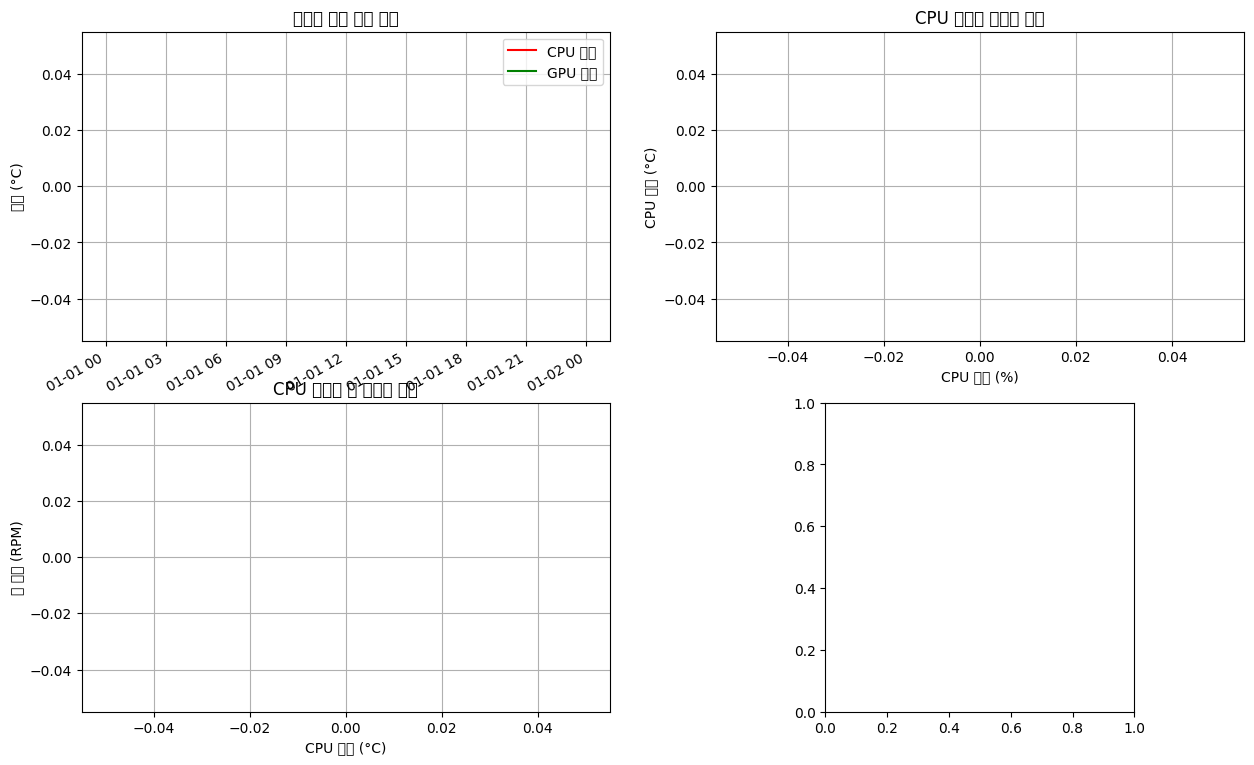

In [13]:
# 10. 실행 예시 (주석 처리된 상태로 제공)

# 예시 1: 기본 데이터 수집 (10분)
#main_workflow(collect_duration=10)

# 예시 2: 외부 데이터셋 통합 (외부 데이터셋 경로 지정)
#main_workflow(collect_duration=5, external_data_path='external_hardware_dataset.csv')

# 예시 3: 기존 데이터로 분석만 수행
#analyze_data('labeled_hardware_data.csv')

# 예시 4: 기존 데이터로 실시간 모니터링만 시작
#model, features = train_anomaly_detection_model('labeled_hardware_data.csv')
#real_time_monitoring(model, features)

# 참고: 실제 실행 시에는 위 예시 중 하나의 주석을 해제하여 사용하세요.
#print("코드가 준비되었습니다. 위 예시 중 하나의 주석을 해제하여 실행하세요.")

## 11. 실행 코드 (이 셀을 실행하여 워크플로우 시작)

In [ ]:
# 11. 실행 코드 (이 셀을 실행하여 워크플로우 시작)
# 아래 코드의 주석을 해제하고 파라미터를 조정하여 실행하세요

# 5분 동안 데이터를 수집하고 모니터링 시스템 구축
# main_workflow(collect_duration=5)

In [14]:
# GPU 정보 확인
!nvidia-smi

# 시스템 정보 확인
!cat /proc/cpuinfo
!cat /proc/meminfo

/bin/bash: line 1: nvidia-smi: command not found
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 